In [1]:
import numpy as np
import os

from glob import glob
from tensorflow.keras.preprocessing.text import text_to_word_sequence
## 라벨인코더-> 카테고리형 문자를 숫자로 자동 변환해주는 역할
from sklearn.preprocessing import LabelEncoder

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## 딥러닝 모델을 만들자!!!!!!!
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing import *


In [2]:
data_dir = os.getcwd() + '/img-animal'
print(data_dir)
os.chdir(data_dir)

/Users/administrator/python-data/data21/book-data/deep04/img-animal


In [3]:
data_list = glob('*.jpg')
data_list[:3]

['dog.1753.jpg', 'cat.1211.jpg', 'dog.775.jpg']

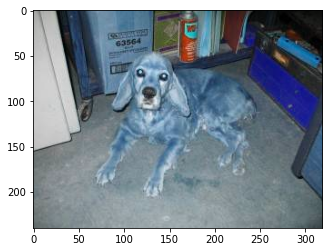

In [4]:
img0 = cv2.imread(data_list[100])
plt.imshow(img0)

In [5]:
img0.shape

(240, 319, 3)

In [6]:
def make_file(data_height, data_width, channel_n, data_list_n):
    ## 라벨링한 결과 넣어줄 1차원 리스트 필요
    label = []
    ## 4차원으로 만들어줄 4차원 리스트 필요
    images = np.zeros((data_list_n, data_height, data_width, channel_n))
    
    encoder = LabelEncoder()
    
    ## 이미지 리스트에서 하나씩 꺼내서 라벨링, 스케일링, 리사이징하자!
    for i, image in enumerate(data_list):
        
        ## 라벨링 : dog.01.jpg
        tokens = text_to_word_sequence(image)
        label.append(tokens[0])
        
        ## 읽어서, 스케일링, 리사이징해서
        image2 = cv2.imread(image)
        image3 = cv2.resize(image2, (data_height, data_width)) / 255
        
        ## 4차원 리스트에 하나씩 끼자
        images[i, :, :, : ] = image3
    label2 = np.array(label)
    label3 = encoder.fit_transform(label2)
    return label3, images

In [7]:
data_height=150
data_width=150
channel_n=3

In [8]:
labels, images = make_file(data_height, data_width, channel_n, 4000)

In [9]:
x = images
y = labels

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size= 0.2,
                                                    random_state=55
                                                   )
print(X_train.shape, X_test.shape)

(3200, 150, 150, 3) (800, 150, 150, 3)


In [17]:
data_height

150

In [23]:
# Pre-trained 모델 가져오기
from tensorflow.keras.applications import ResNet50
cnn_base = ResNet50(include_top=False, weights='imagenet', 
                 input_shape=[data_height, data_width, channel_n],classes=2)  

In [30]:
model = Sequential()
### 특성추출 레이어를 쌓아준다.

# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(data_height, data_width, channel_n)))
# model.add(MaxPool2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPool2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))

### 딥러닝 학습 레이어를 쌓아준다.
### 입력--히든--출력 순서대로 쌓아준다.
### 입력(1개)-- 1차원이여야함.

model.add(cnn_base) 
model.add(Flatten()) ## 이미지 데이터를 1차원으로 만들어주는 객체 
### 히든
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(12, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(5, activation='relu'))
model.add(Dropout(rate=0.3))

### 출력(1개)-- 딥러닝하는 학습의 종류에 따라 다르게 써주어야 함.!!
### 이진 분류인 경우(1, sigmoid)
### 다중 분류인 경우(n, softmax)
### 회귀인 경우(1, linear)
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 128)               6553728   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)              

In [31]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
             )

In [32]:
es = EarlyStopping(patience=3, restore_best_weights=True)
cp = ModelCheckpoint('best_cnn_final.h5')

In [ ]:
cnn_history = model.fit(
                X_train,
                y_train,
                batch_size=128,
                epochs=10,
                validation_data= (X_test, y_test), 
                callbacks=[es, cp],
                verbose=2
)

In [ ]:
test_result = model.evaluate(X_test,y_test) 
test_result

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1) ## 1행2열의 도표, 1열
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('model acc.')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train_acc','test_acc'])

plt.subplot(1, 2, 2) ## 1행2열의 도표, 2열
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','test_loss'])

In [ ]:
load_model_final = load_model('./best_cnn_final.h5')
load_model_final

In [ ]:
final_result2 = load_model_final.predict(X_test)
final_result2[:10]

In [ ]:
y_test[:10]

In [ ]:
final_result3 = []
for x in final_result2:
    if x > 0.5 :
        final_result3.append(1)
    else:
        final_result3.append(0)
final_result3[:10]

In [ ]:
np.mean(final_result3 == y_test)